[Last time, we made a neat little implementation of a 2D Ising model simulation](/posts/parallelizable-numpy-implementation-of-2d-ising-model), and we showed that it looks reasonable. Well, that it might, but we can't be certain of that! I know I said that next time we would, er, `%timeit`, put it on the GPU and make it GO FAST, but perhaps it's a better idea to start with some data analysis first, making sure the result we're getting are quantitatively what we would like them to be - physical.

<!-- TEASER_END -->

One more errata: conveniently forgetting to mention that we were working with the assumption that there's no external magnetic field. Let it be known that we're neglecting any external magnetic field. Let's resummarize the results here:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

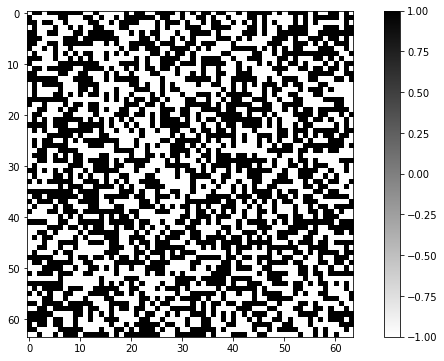

In [2]:
plt.rcParams['figure.figsize'] = [11, 6]  # for larger pictures
size = (64, 64)

np.random.seed(0)
a = np.random.randint(low=0, high=2, size=size) * 2 - 1
plt.imshow(a, cmap='binary')
plt.colorbar();

I'll modify the `better_iteration` function we arrived at in two ways: the name could be *better*, as in, it tries to flip half the spins on the grid, so we'll call it `half_iteration`. We'll also make it so that the spin matrix `a` is modified in-place, without copying, to save memory and computation time:

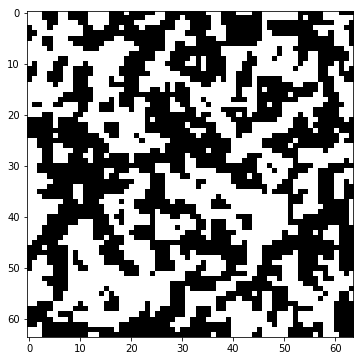

In [3]:
def half_iteration(a, mask, J = 1, beta = 1):
    interactions = np.roll(a, 1, 0) + np.roll(a, 1, 1) + np.roll(a, -1, 0) + np.roll(a, -1, 1)
    deltaE = 2 * J * a * interactions
    boltzmann = np.exp(-beta * deltaE) * mask
    flip_these = np.random.random(a.shape) < boltzmann
    a[flip_these] *= -1

# make a checkerboard pattern to preserve causality, updating spins on alternating diagonals in each iteration
def mask(a):
    a_mask = np.ones_like(a)
    a_mask[::2, ::2] = 0
    a_mask[1::2, 1::2] = 0
    return a_mask

def full_iteration(a, mask, J = 1, beta = 1):
    # this now becomes a VERY thin wrapper!
    half_iteration(a, mask, J, beta)
    half_iteration(a, 1-mask, J, beta)


a_mask = mask(a)
full_iteration(a, a_mask)
plt.imshow(a, cmap='binary')

We are now in the exact spot where we left off a week ago. Let's do some quantitative calculation now!

There are three main diagnostics (that I know of) that you would be interested in when looking at this kind of system:

1. the average magnetization, which is simply the average of all spins
2. the internal energy, which is `-0.5 * deltaE` in our `half_iteration` code for each spin (and globally, we would take the average of that, so technically it's the average internal energy per spin)
3. the heat capacity, which is the partial derivative of internal energy with respect to the temperature

The first two can be grabbed straightforwardly from each snapshot of the iteration, and then averaged to decrease the effect of fluctuations. The third, [as seen on Richard Fitzpatrick's website](http://farside.ph.utexas.edu/teaching/329/lectures/node110.html), can be calculated as

$$C_v = \frac{dU}{dT} = \frac{\sigma_U^2}{k_B T^2} $$
Let's get to it!

In [4]:
def magnetization(a):
    return a.mean(), a.std()

def internal_energy(a, J = 1):
    interactions = np.roll(a, 1, 0) + np.roll(a, 1, 1) + np.roll(a, -1, 0) + np.roll(a, -1, 1)
    current_energy = -J * a * interactions
    return current_energy.mean(), current_energy.std()

magnetization(a), internal_energy(a)

((0.0205078125, 0.9997896926986519), (-2.123046875, 1.816938556075228))

Well, that's a whole lot of variance! Our system has definitely not converged to any stable state yet. Let's repeat that after a bunch of iterations:

((0.9990234375, 0.04418338291352976), (-3.9921875, 0.19748788530882092))

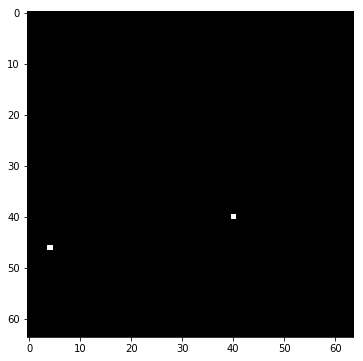

In [5]:
a_bunch = 100
for i in range(a_bunch):
    full_iteration(a, a_mask)

plt.imshow(a, cmap='binary')
magnetization(a), internal_energy(a)

Well, that's better. A little bleak, but it certainly seems stable.

All right! This is what we wanted. The system has nearly converged to a stable state, so its magnetization (remember that we're way under the critical temperature) is almost fully in one direction, and the internal energy is way lower than what we've had before, suggesting that this state is much closer to equilibrium.

Let's try to get the energies and plot this:

In [6]:
k_b = 1
T_range = np.linspace(1.5, 3.5, 300)
iterations = 100
energies = []
magnetizations = []
for T in tqdm_notebook(T_range):
    beta = 1 / (k_b * T)
    np.random.seed(0)
    a = np.random.randint(low=0, high=2, size=size) * 2 - 1
    a_mask = mask(a)
    for i in range(iterations):
        full_iteration(a, a_mask, beta=beta)
    energies.append(internal_energy(a))    
    magnetizations.append(magnetization(a))   

E, dE = np.array(energies).T
M, dM = np.array(magnetizations).T

We'll also need a bunch of plots, and we'd like to use $C_v$ to let us find the critical temperature as exhibited by our simulation as its maximum. Let's stick the analysis we want into a function:

2.2959866220735785

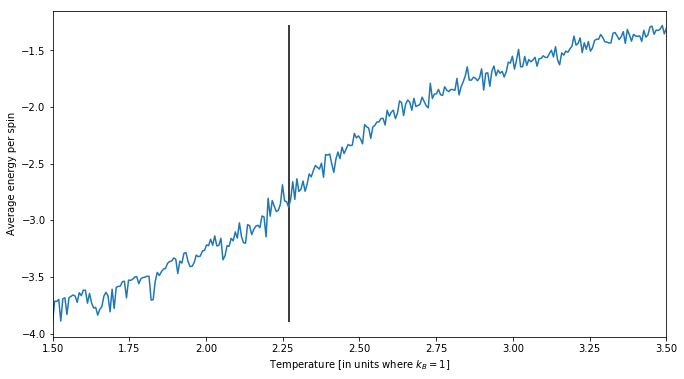

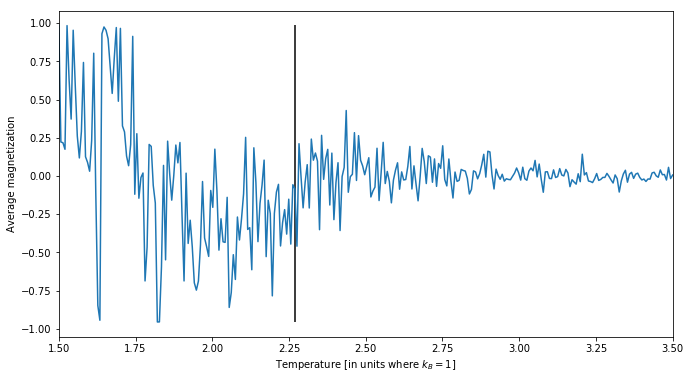

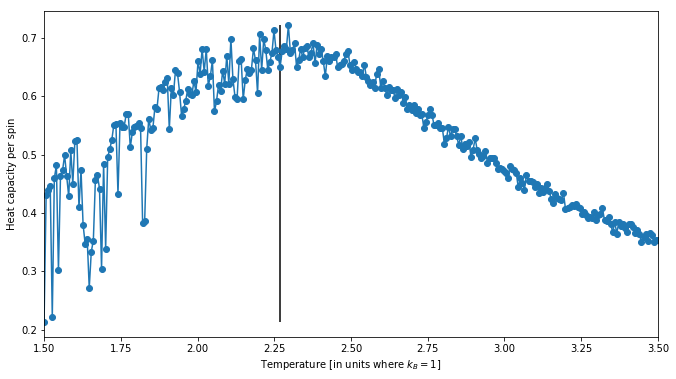

In [7]:
Onsager_critical_temperature = 2 / np.log(1 + 2**0.5)  # a theoretical value

def analysis(T_range, E, dE, M, dM, plotting=True):
    Cv = dE**2 / k_b / T_range**2  # see Fitzpatrick
    maximum_index = np.argmax(Cv)
    our_critical_temperature = T_range[maximum_index]
    if plotting:
        plt.plot(T_range, E)
        plt.xlabel(r"Temperature [in units where $k_B = 1$]")
        plt.ylabel("Average energy per spin")
        plt.xlim(T_range.min(), T_range.max());
        plt.vlines(Onsager_critical_temperature, E.min(), E.max())

        plt.figure()

        plt.plot(T_range, M)
        plt.xlabel(r"Temperature [in units where $k_B = 1$]")
        plt.ylabel("Average magnetization")
        plt.xlim(T_range.min(), T_range.max());
        plt.vlines(Onsager_critical_temperature, M.min(), M.max())


        plt.figure()
        plt.plot(T_range, Cv, "o-")
        plt.xlabel(r"Temperature [in units where $k_B = 1$]")
        plt.ylabel("Heat capacity per spin")
        plt.xlim(T_range.min(), T_range.max());
        plt.vlines(Onsager_critical_temperature, Cv.min(), Cv.max())

    return our_critical_temperature
analysis(T_range, E, dE, M, dM)

And if I've ever seen a plot that says nothing, it's this one. It seems all random. There's a simple issue underneath this: since we're starting from a randomized grid, there is no telling which spin state the system will converge to at a low temperature. Note how there's much less noise above the critical temperature as found by Onsager back in 1944, as denoted by the vertical line. This makes intuitive sense: above the critical temperature the system converges to an essentially random state, and each of those is basically equivalent.

Let's try this again, from a **cold start** (all spins up):

2.322742474916388

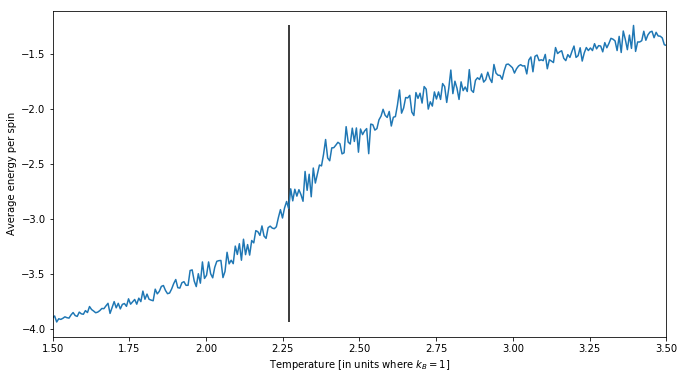

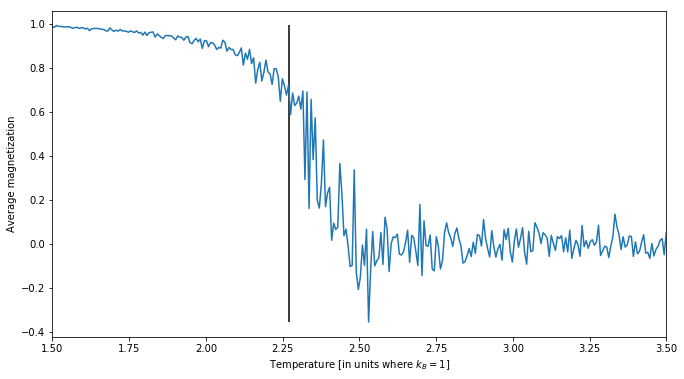

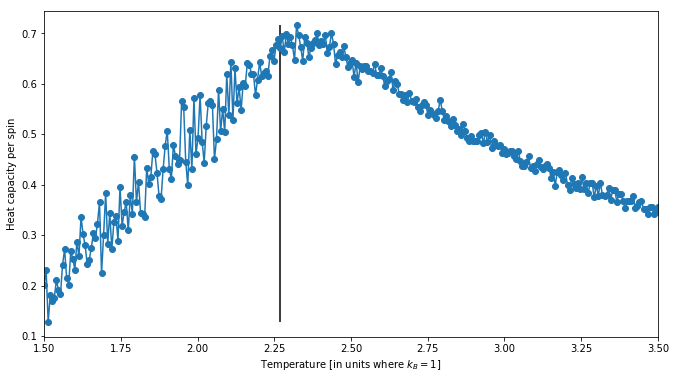

In [8]:
energies = []
magnetizations = []
for T in tqdm_notebook(T_range):
    beta = 1 / (k_b * T)
    a = np.ones(size)
    a_mask = mask(a)
    for i in range(iterations):
        full_iteration(a, a_mask, beta=beta)
    energies.append(internal_energy(a))    
    magnetizations.append(magnetization(a))   

E, dE = np.array(energies).T
M, dM = np.array(magnetizations).T

analysis(T_range, E, dE, M, dM)

That's a bit better, but not quite enough. The measurement  is still noisy. What we need to do is average the energies and magnetizations over a bunch of iterations. We'll also stick our entire logic into a function:

2.32943143812709

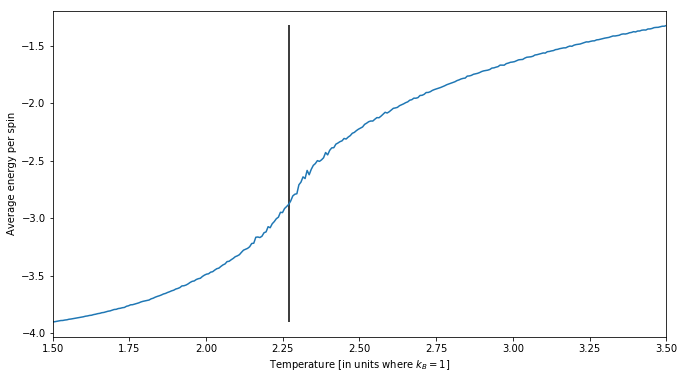

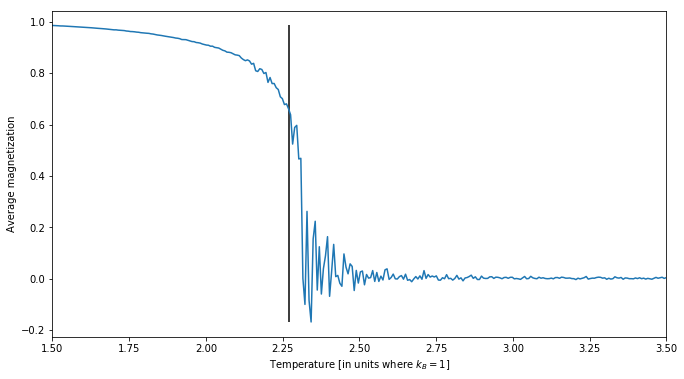

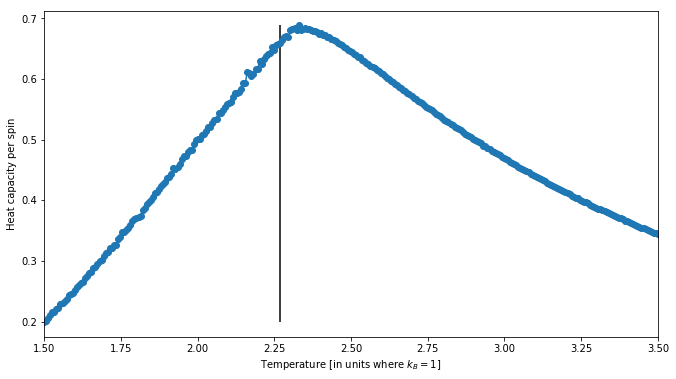

In [9]:
def simulation(iterations, size=size, T_range=T_range, k_b=k_b, plotting=True):
    energies = []
    magnetizations = []
    a_mask = np.ones(size)
    a_mask[::2, ::2] = 0
    a_mask[1::2, 1::2] = 0
    
    for T in tqdm_notebook(T_range):
        beta = 1 / (k_b * T)
        a = np.ones(size)
        E = np.zeros(2)
        M = np.zeros(2)
        for i in range(iterations):
            E += internal_energy(a)
            M += magnetization(a)
            full_iteration(a, a_mask, beta=beta)
        energies.append(E / iterations)
        magnetizations.append(M / iterations)   

    E, dE = np.array(energies).T
    M, dM = np.array(magnetizations).T
    return analysis(T_range, E, dE, M, dM, plotting)
simulation(1000)

So we're getting relatively good agreement with [Fitzpatrick's results](http://farside.ph.utexas.edu/teaching/329/lectures/node110.html), but on the other hand... our critical temperature is slightly off and the peak is not as sharp as it should probably be. Perhaps this is an issue of small grid size?

2.3361204013377925

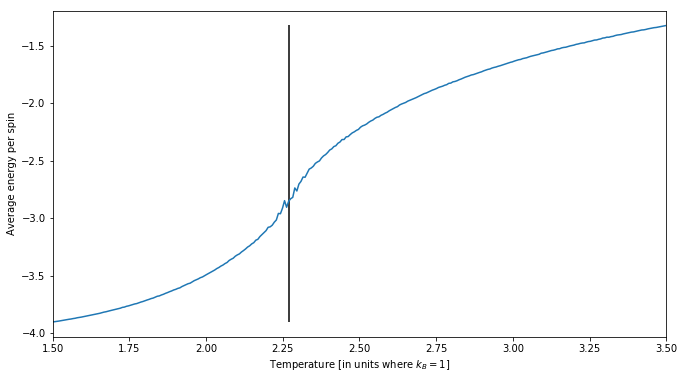

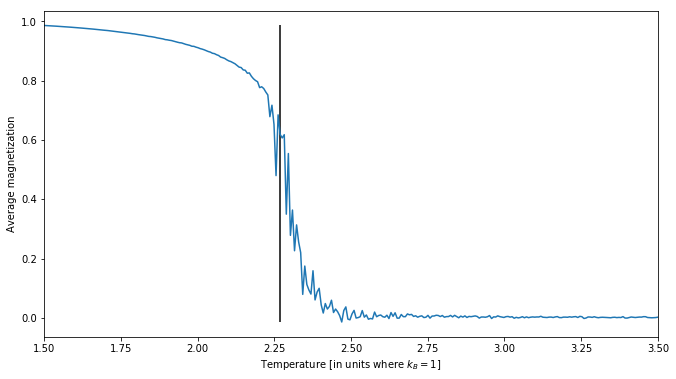

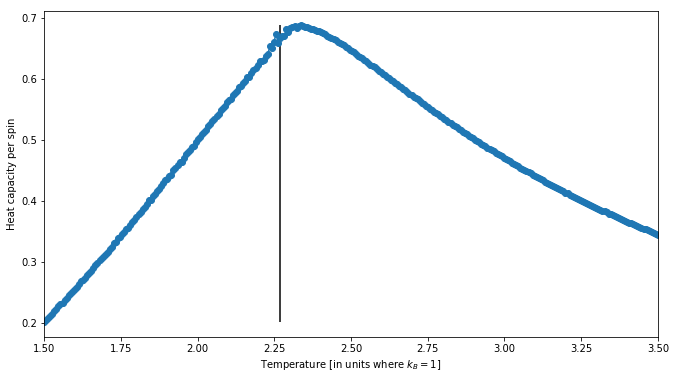

In [10]:
simulation(1000, (128, 128))

Okay, and what if we go in the other direction, towards smaller sizes:

2.3896321070234112

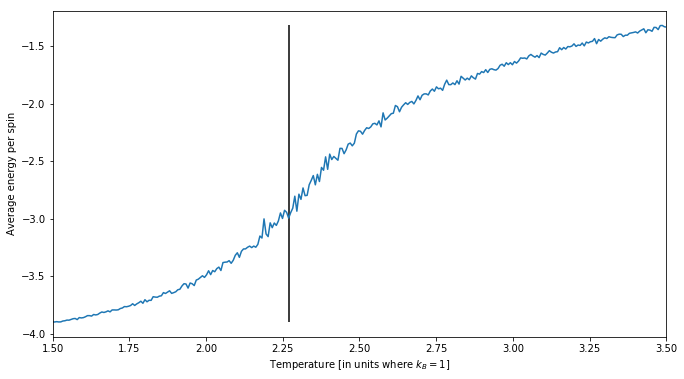

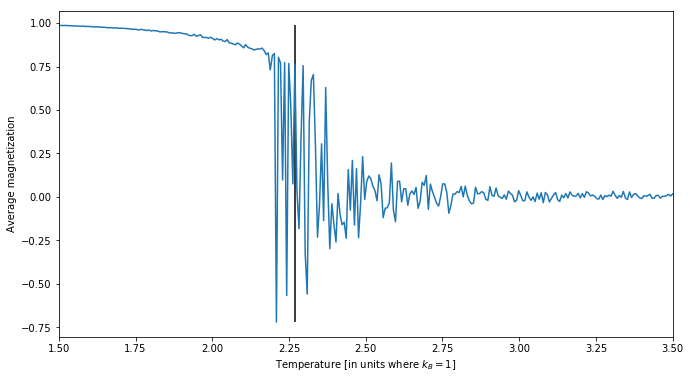

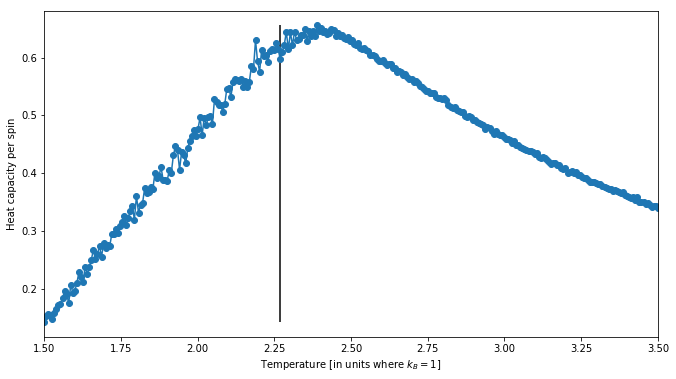

In [11]:
simulation(500, (16, 16))

Interestingly, while the peak's behavior is not changing, the estimated critical temperature does change a bit. However, I'm trying to write this blog in half-hour chunks, and running multiple simulations does eat into that period. In other words, while we have shown that the magnetization and internal energy qualitatively behave just as they should for these few runs, it'd be nice to find out whether we converge to the critical temperature - and we're going to need to run a whole bunch of simulations to do that. We do need to speed this up, after all!